***Fit BATMAN to a real light curve***

let’s do an end-to-end example: download a real Kepler/TESS light curve, clean it, and fit a BATMAN transit model to measure 
𝑅
𝑝
/
𝑅
⋆
R
p
	​

/R
⋆
	​

 (with uncertainties via emcee). The notebook below is robust: it checks for missing data, flattens/detrends the light curve using lightkurve, extracts the transit window, and then runs an MCMC fit for rp and t0 (keeping period, a/Rs, inclination fixed to literature values). You can adapt it to other targets by changing target_name and period.

**Explanations / notes**

Choosing period: for a real system, use literature ephemeris (period) — lightkurve doesn’t supply the planet period for arbitrary targets. If you don’t know the period, you can run BoxLeastSquares on the light curve (I can show that module later).

a/Rs and inclination: I kept these fixed (approximate). If you have literature values use them. If not, you can let them float — but then the parameter space grows and MCMC needs more walkers/steps.

Flux error (flux_err): I used the sample standard deviation over the selected window; for a more accurate fit use lc.flux_err from Kepler/TESS data if available.

Flattening: lc.flatten() is usually the easiest and robust approach to remove stellar variability before folding. Tweak window_length.

Run time: MCMC may take several minutes depending on machine and number of samples. If you want a faster (but less Bayesian) estimate, use scipy.optimize.curve_fit to fit only rp and t0 with batman (we did that earlier).

If .download() returns None: the search might not have useful results. Use print(search) and choose a different search[<index>] result or another target.

In [1]:
# Fit BATMAN to a real Kepler/TESS light curve (estimate Rp/Rs)
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import batman
import emcee
import corner
from tqdm.auto import tqdm

# -------------------------
# USER INPUT: choose a target and its known period (days).
# Kepler examples known to be in Kepler: "Kepler-10" (P ~ 0.8375 d)
# TESS examples: provide TIC id or target name known to be in TESS.
# Replace these values if you want a different target.
# -------------------------
target_name = "Kepler-10"    # change as needed
mission = "Kepler"           # "Kepler" or "TESS"
period = 0.8375              # days; use literature value for the planet

c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
# -------------------------
# 1) Search + download a light curve
# -------------------------
search = lk.search_lightcurve(target_name, mission=mission)
print(search[:5])  # show top results (if any)
lc = None
if len(search) > 0:
    lc = search[0].download()
if lc is None:
    raise ValueError(f"No light curve downloaded for {target_name} in {mission}. Try another target or mission.")

SearchResult containing 5 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 02 2009 Kepler      60 kplr011904151      0.0
  1 Kepler Quarter 03 2009 Kepler      60 kplr011904151      0.0
  2 Kepler Quarter 03 2009 Kepler      60 kplr011904151      0.0
  3 Kepler Quarter 03 2009 Kepler      60 kplr011904151      0.0
  4 Kepler Quarter 00 2009 Kepler    1800 kplr011904151      0.0


<Figure size 1200x300 with 0 Axes>

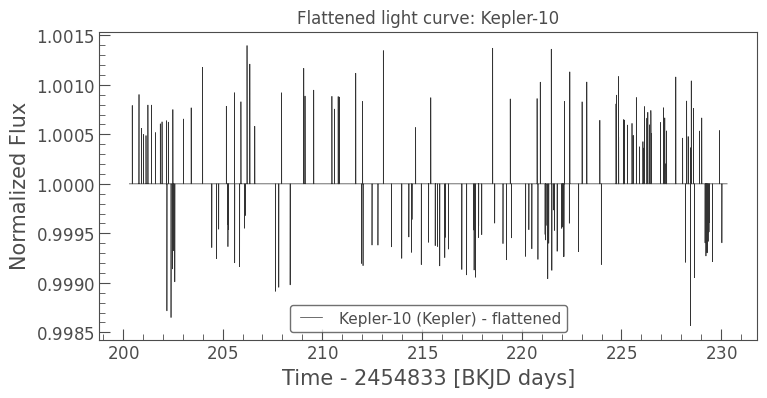

In [3]:
# -------------------------
# 2) Clean / flatten the light curve
#    - remove nans, apply quality masks, flatten to remove long-term trends
# -------------------------
lc = lc.remove_nans().remove_outliers(sigma=5)  # basic cleaning
try:
    # lightkurve has .flatten() to remove long-term trends; tune window_length for your data
    lc_flat = lc.flatten(window_length=401, break_tolerance=0.5)  # adjust window_length if necessary
except Exception:
    # fallback to simple median detrend if flatten fails
    flux = lc.flux
    trend = np.median(flux)
    lc_flat = lc.copy()
    lc_flat = lc_flat.normalize()

# normalize
lc_flat = lc_flat.normalize()

# Plot the full flattened light curve
plt.figure(figsize=(12,3))
lc_flat.plot(label=f"{target_name} ({mission}) - flattened")
plt.title(f"Flattened light curve: {target_name}")
plt.show()

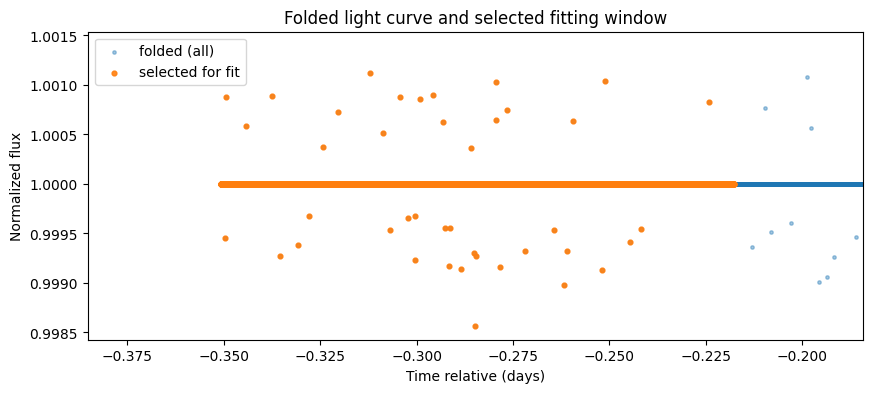

In [4]:
# -------------------------
# 3) Fold and inspect around transit
# -------------------------
# We'll fold on the provided period and identify the transit center by simple min flux
folded = lc_flat.fold(period=period)
# convert to arrays for easier manipulation
time_fold = folded.time.value  # in days, phased (-0.5..0.5)
flux_fold = folded.flux.value

# shift phases to center on transit where flux is minimum
min_idx = np.nanargmin(flux_fold)
t0_phase = time_fold[min_idx]  # this is a phase in [-0.5,0.5]

# choose a window around t0 to fit (e.g., ±0.1 in phase => ±0.1*period days)
phase_window = 0.08
mask = (time_fold > (t0_phase - phase_window)) & (time_fold < (t0_phase + phase_window))
t_fit = time_fold[mask] * period  # convert phase to days relative to epoch (approx)
flux_fit = flux_fold[mask]

# Plot folded + selected window
plt.figure(figsize=(10,4))
plt.scatter(time_fold * period, flux_fold, s=6, alpha=0.4, label="folded (all)")
plt.scatter(t_fit, flux_fit, s=12, alpha=0.9, label="selected for fit")
plt.xlim((t0_phase - 0.12) * period, (t0_phase + 0.12) * period)
plt.xlabel("Time relative (days)")
plt.ylabel("Normalized flux")
plt.legend()
plt.title("Folded light curve and selected fitting window")
plt.show()

In [5]:
# -------------------------
# 4) Build a BATMAN model builder function
#    We'll fix: period (per), a/Rs (a), inclination (inc), ecc=0, limb-darkening
#    and fit for: rp (Rp/Rs), t0 (mid-transit time offset), and also allow a linear baseline.
# -------------------------
# USER: choose a/Rs and inclination from literature or approximate:
a_over_rs = 15.0   # approximate; change if you know the system
inc_deg = 87.0     # approximate

# For batman we need absolute times; we'll set an arbitrary epoch reference
# t_fit is currently time relative to folded epoch; we'll use small absolute times around 0.
times = t_fit.copy()

def make_batman_params(per, t0, rp, a, inc, u=[0.1,0.3], limb_dark='quadratic'):
    m = batman.TransitParams()
    m.t0 = t0
    m.per = per
    m.rp = rp
    m.a = a
    m.inc = inc
    m.ecc = 0.0
    m.w = 90.0
    m.limb_dark = limb_dark
    m.u = u
    return m

def batman_model_flux(times, per, t0, rp, a, inc, u=[0.1,0.3]):
    params = make_batman_params(per, t0, rp, a, inc, u=u)
    model = batman.TransitModel(params, times)
    return model.light_curve(params)

In [6]:
# -------------------------
# 5) Define log-prob function for MCMC
#    We'll model a multiplicative linear baseline: flux_model = baseline*(1 + c1*(t - t_center)) * batman_model
# -------------------------
t_center = 0.0  # center of fitting window in days (we used fold center)
flux_err = np.nanstd(flux_fit)  # rough noise estimate; you can refine

def log_prior(theta):
    rp, t0, c1, baseline = theta
    if 0.0001 < rp < 0.5 and -0.1*period < t0 < 0.1*period and -0.5 < c1 < 0.5 and 0.8 < baseline < 1.2:
        return 0.0
    return -np.inf

def log_likelihood(theta, times, flux, flux_err):
    rp, t0, c1, baseline = theta
    model = batman_model_flux(times, period, t0, rp, a_over_rs, inc_deg)
    # apply linear multiplicative baseline
    model = baseline * (1.0 + c1*(times - t_center)) * model
    # gaussian likelihood
    return -0.5 * np.sum(((flux - model)/flux_err)**2 + np.log(2*np.pi*flux_err**2))

def log_probability(theta, times, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, times, flux, flux_err)

In [7]:
# -------------------------
# 6) Setup and run MCMC (emcee)
# -------------------------
ndim = 4
nwalkers = 48
# initial guesses: rp ~ 0.1, t0 ~ 0, c1=0, baseline=1
initial = np.array([0.1, 0.0, 0.0, 1.0])
pos = initial + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(times, flux_fit, flux_err))
print("Running MCMC (this may take a minute)...")
sampler.run_mcmc(pos, 2500, progress=True)

Running MCMC (this may take a minute)...


100%|██████████| 2500/2500 [02:02<00:00, 20.39it/s]


State([[ 2.66854322e-01  5.06145613e-02 -1.33647376e-05  9.99995416e-01]
 [ 4.43132170e-01 -3.16001774e-03 -4.63116527e-05  9.99987072e-01]
 [ 5.00996156e-02  4.78441141e-03  1.16619226e-05  1.00000319e+00]
 [ 1.78928625e-02 -2.79277130e-02 -7.00809779e-06  9.99998422e-01]
 [ 2.33968806e-01 -3.76622699e-02  1.29376595e-05  1.00000333e+00]
 [ 6.28410714e-02  2.63898325e-02  5.90835299e-06  1.00000040e+00]
 [ 1.48432076e-01  6.04007914e-02 -1.24353786e-05  9.99996850e-01]
 [ 1.53453891e-01 -2.93913611e-02  9.92847284e-06  1.00000223e+00]
 [ 5.70531105e-02 -7.03422474e-02  1.24074472e-05  1.00000370e+00]
 [ 3.47882092e-01  5.61607771e-02 -5.06710161e-06  9.99999155e-01]
 [ 4.88037223e-01 -1.66623614e-03  8.34207503e-06  1.00000188e+00]
 [ 1.40849473e-01  1.48469034e-02 -1.72254814e-05  9.99994761e-01]
 [ 1.12840166e-01  4.96996173e-02 -2.74348239e-05  9.99991355e-01]
 [ 2.89883074e-02 -2.89571636e-02 -1.14774456e-05  9.99997898e-01]
 [ 1.62984851e-01  3.86623200e-02 -2.97274109e-05  9.999

Samples shape: (8160, 4)
rp: 0.23991 (+0.18051/-0.16540)
t0: -0.00242 (+0.05849/-0.05563)
c1: -0.00001 (+0.00001/-0.00002)
baseline: 1.00000 (+0.00000/-0.00000)


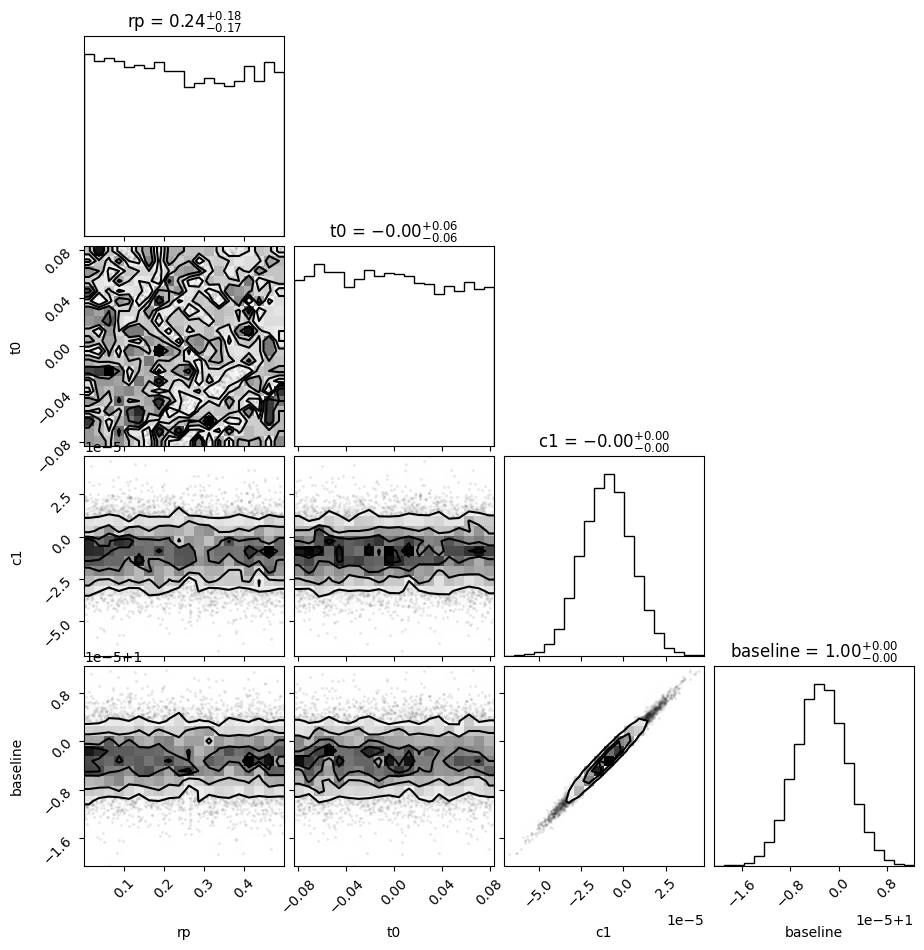

In [8]:
# -------------------------
# 7) Inspect results
# -------------------------
burn = 800
thin = 10
samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
labels = ["rp", "t0", "c1", "baseline"]
print("Samples shape:", samples.shape)

# Print median and 1-sigma
for i, lab in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16,50,84])
    q = np.diff(mcmc)
    print(f"{lab}: {mcmc[1]:.5f} (+{q[1]:.5f}/-{q[0]:.5f})")

# corner plot
fig = corner.corner(samples, labels=labels, truths=None, show_titles=True)
plt.show()


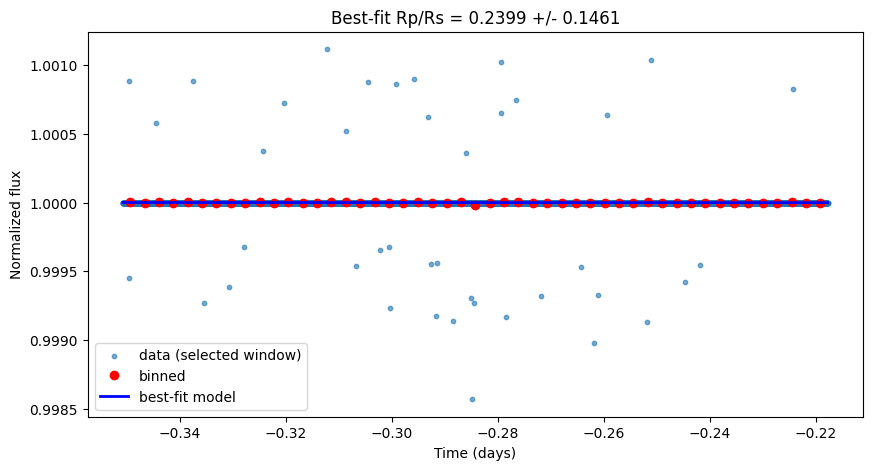

In [9]:
# -------------------------
# 8) Plot best-fit model vs data
# -------------------------
best = np.median(samples, axis=0)
rp_best, t0_best, c1_best, baseline_best = best

model_best = batman_model_flux(times, period, t0_best, rp_best, a_over_rs, inc_deg)
model_best = baseline_best * (1.0 + c1_best*(times - t_center)) * model_best

plt.figure(figsize=(10,5))
plt.scatter(times, flux_fit, s=10, alpha=0.6, label='data (selected window)')
# overplot binned data for clarity
bins = np.linspace(times.min(), times.max(), 50)
digit = np.digitize(times, bins)
bin_centers = 0.5*(bins[:-1] + bins[1:])
bin_mean = np.array([np.nanmean(flux_fit[digit==i]) for i in range(1,len(bins))])
plt.plot(bin_centers, bin_mean, 'ro', label='binned')

# model
tplot = np.linspace(times.min(), times.max(), 500)
modplot = batman_model_flux(tplot, period, t0_best, rp_best, a_over_rs, inc_deg)
modplot = baseline_best * (1.0 + c1_best*(tplot - t_center)) * modplot
plt.plot(tplot, modplot, 'b-', lw=2, label='best-fit model')

plt.xlabel("Time (days)")
plt.ylabel("Normalized flux")
plt.legend()
plt.title(f"Best-fit Rp/Rs = {rp_best:.4f} +/- {np.std(samples[:,0]):.4f}")
plt.show()